In [1]:
import importlib
import os
import sys
sys.path.append(os.path.join('..'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from disruptsc.parameters import Parameters
from disruptsc.model.model import Model
import disruptsc.paths as paths
import disruptsc.network.transport_network

In [4]:
scope = "ECA"
parameters = Parameters.load_parameters(paths.PARAMETER_FOLDER, scope)
parameters.export_files = False
parameters.adjust_logging_behavior(export_log_file=False)
model = Model(parameters)

In [5]:
import disruptsc.network.transport_network
from disruptsc.network.transport_network import TransportNetwork

In [6]:
model.setup_transport_network(True)

2025-03-07 15:44:25,798 - root - INFO - Transport network generated from temp file.
2025-03-07 15:44:25,954 - root - INFO - Total length of transport network is: 249933 km
2025-03-07 15:44:25,956 - root - INFO - maritime: 61760 km
2025-03-07 15:44:25,957 - root - INFO - multimodal: 6 km
2025-03-07 15:44:25,957 - root - INFO - pipelines: 21064 km
2025-03-07 15:44:25,958 - root - INFO - railways: 16172 km
2025-03-07 15:44:25,959 - root - INFO - roads: 150931 km
2025-03-07 15:44:25,964 - root - INFO - Nb of nodes: 8124, nb of edges: 12195


In [7]:
model.transport_network.ingest_logistic_data(parameters.logistics)

In [8]:
model.setup_agents(True)

2025-03-07 15:44:27,946 - root - INFO - Firms, households, and countries generated from temp file.
2025-03-07 15:44:27,948 - root - INFO - Nb firms: 2483
2025-03-07 15:44:27,949 - root - INFO - Nb households: 49
2025-03-07 15:44:27,950 - root - INFO - Nb countries: 12


In [17]:
from disruptsc.network.mrio import Mrio
filepath = r"C:\Users\Celian\OneDrive\WorldBank\ECA\Data\Structured\MRIO\mrio_russia_2.csv"
mrio2 = Mrio.load_mrio_from_filepath(filepath, model.parameters.monetary_units_in_data)

2025-03-07 10:39:07,225 - root - WARNING - Failed to detect the label used for value.?added in the MRIO


In [53]:
edge_attr = attr
logistic_parameters = parameters.logistics

In [54]:
edge_attr['km'] * logistic_parameters['basic_cost'][edge_attr['type']]

0.001

In [56]:
def _get_speed(edge_attr: dict, speed_dict: dict) -> float:
    if edge_attr['type'] == "roads":
        if edge_attr['class'] == 'primary':
            return speed_dict['roads']['primary']
        elif edge_attr['class'] == 'secondary':
            return speed_dict['roads']['primary']
        elif edge_attr['class'] == 'tertiary':
            return speed_dict['roads']['primary']
        else:
            if edge_attr['surface'] == 'paved':
                return speed_dict['roads']['paved']
            elif edge_attr['surface'] == 'unpaved':
                return speed_dict['roads']['unpaved']
            else:
                return speed_dict['roads']['paved']
    elif edge_attr['type'] in ['railways', 'waterways', 'maritime', 'airways', "pipelines"]:
        return speed_dict[edge_attr['type']]
    elif edge_attr['type'] == "multimodal":
        return speed_dict['roads']['paved']  # these are very small links, so we assume paved roads


def _get_loading_time_and_fee(edge_attr: dict, loading_times: dict, loading_fees: dict) -> (float, float):
    if edge_attr['type'] == "multimodal":
        return loading_times[edge_attr['multimodes']], loading_fees[edge_attr['multimodes']]
    else:
        return 0.0, 0.0


def _get_border_crossing_time_and_fee(edge_attr: dict, border_crossing_times: dict,
                                      border_crossing_fees: dict) -> (float, float):
    if isinstance(edge_attr['special'], str):
        if "custom" in edge_attr['special']:
            return border_crossing_times[edge_attr['type']], border_crossing_fees[edge_attr['type']]
    return 0.0, 0.0


In [61]:
basic_cost = edge_attr['km'] * logistic_parameters['basic_cost'][edge_attr['type']]
transport_time = edge_attr['km'] / _get_speed(edge_attr, logistic_parameters['speeds'])
loading_time, loading_fee = _get_loading_time_and_fee(
    edge_attr, logistic_parameters['loading_times'], logistic_parameters['loading_fees'])
border_crossing_time, border_crossing_fee = _get_border_crossing_time_and_fee(
    edge_attr, logistic_parameters['border_crossing_times'], logistic_parameters['border_crossing_fees'])
total_time = transport_time + loading_time + border_crossing_time
total_fee = loading_fee + border_crossing_fee
cost_per_ton = basic_cost + total_fee + total_time * logistic_parameters['cost_of_time']

In [62]:
print(basic_cost, transport_time, loading_time, loading_fee, 
      border_crossing_time, border_crossing_fee, 
      total_time, total_fee,
      cost_per_ton)

0.001 0.0016666666666666668 12 2.2 0.0 0.0 12.001666666666667 2.2 8.081816666666667


In [43]:
for edge, attr in model.transport_network.edges.items():
    if attr['type'] == "multimodal":
        break

In [35]:
model.transport_network.provide_shortest_route(896, 362, "container", "cost_per_ton").transport_modes

['roads']

In [39]:
nx.get_edge_attributes(model.transport_network, "weight_container")

{}

In [37]:
model.transport_network.provide_shortest_route(1117, 1531, "solid_bulk", route_weight="weight", noise_level=0).transport_modes

['airways', 'multimodal', 'roads']

In [10]:
model.setup_sc_network(True)

2025-03-07 15:45:47,906 - root - INFO - Supply chain generated from temp file.


In [142]:
model.set_initial_conditions()

2025-03-07 16:55:41,045 - root - INFO - Setting initial conditions to input-output equilibrium


In [70]:
import networkx as nx

In [153]:
model.households['hh_0'].spending_per_retailer[0]

2.042892752662475

In [138]:
model.households['hh_0'].receive_products_and_pay(model.sc_network, model.transport_network, 
                                                parameters.sectors_no_transport_network, parameters.transport_to_households)

In [151]:
commercial_link = model.sc_network[model.firms[0]][model.households['hh_0']]['object']
print(commercial_link.order, commercial_link.delivery)

2.042892752662475 2.042892752662475


In [152]:
model.firms[0].product_stock

np.float64(-5.9674487573602164e-15)

In [ ]:
sc_network[edge[0]][self]['object'].product_type

In [131]:
model.firms[0].deliver_products(model.sc_network, model.transport_network, model.transport_network,
                                   sectors_no_transport_network=parameters.sectors_no_transport_network,
                                   rationing_mode=parameters.rationing_mode,
                                   explicit_service_firm=parameters.explicit_service_firm,
                                   transport_to_households=parameters.transport_to_households,
                                   monetary_units_in_model=parameters.monetary_units_in_model,
                                   cost_repercussion_mode=parameters.cost_repercussion_mode,
                                   price_increase_threshold=parameters.price_increase_threshold,
                                   capacity_constraint=parameters.capacity_constraint,
                                   transport_cost_noise_level=parameters.transport_cost_noise_level)

In [78]:
firm_connectivity_matrix = nx.adjacency_matrix(
            model.sc_network,
            # graph.subgraph(list(graph.nodes)[:-1]),
            weight='weight',
            nodelist=model.firms.values()
        ).todense()
import_weight_per_firm = [
    sum([
        model.sc_network[supply_edge[0]][supply_edge[1]]['weight']
        for supply_edge in model.sc_network.in_edges(firm)
        if model.sc_network[supply_edge[0]][supply_edge[1]]['object'].category == 'import'
    ])
    for firm in model.firms.values()
]
n = len(model.firms)

In [80]:
import numpy as np

In [105]:
final_demand_vector = np.zeros((len(model.firms), 1))

firm_id_to_position_mapping = {firm_id: i for i, firm_id in enumerate(model.firms.get_properties("pid"))}

# Collect households final demand
for household in model.households.values():
    for retailer_id, quantity in household.purchase_plan.items():
        if isinstance(retailer_id, int):  # we only consider purchase from firms, not from other countries
            final_demand_vector[(firm_id_to_position_mapping[retailer_id], 0)] += quantity

# Collect country final demand
for country in model.countries.values():
    for supplier_id, quantity in country.purchase_plan.items():
        if isinstance(supplier_id, int):  # we only consider purchase from firms, not from other countries
            final_demand_vector[(firm_id_to_position_mapping[supplier_id], 0)] += quantity

In [106]:
eq_production_vector = np.linalg.solve(
    np.eye(n) - firm_connectivity_matrix,
    final_demand_vector  # + 0.01
)

In [107]:
eq_production_vector

array([[17.22303537],
       [ 2.26973036],
       [ 0.47751536],
       ...,
       [ 0.63471084],
       [ 0.09462306],
       [ 1.620135  ]])

In [104]:
final_demand_vector

array([[1.16067019e+01],
       [1.69970138e+00],
       [4.08107921e-01],
       ...,
       [2.54822104e-03],
       [2.54385557e-02],
       [3.81211104e-05]])

In [95]:
qty = 0
for i in list(range(12)) + [19]:
    qty += model.households['hh_'+str(i)].purchase_plan[0]
qty

5.6163334977675285

In [101]:
final_demand_vector

array([[1.72230354e+01],
       [2.26973036e+00],
       [4.77515364e-01],
       ...,
       [3.65201544e-01],
       [7.59300109e-02],
       [3.81211104e-05]])

In [12]:
model.setup_logistic_routes(True)

2025-03-07 15:45:50,217 - root - INFO - Logistic routes generated from temp file.


In [25]:
from disruptsc.simulation.simulation import Simulation

In [143]:
simulation = Simulation("criticality")

In [150]:
model.run_one_time_step(time_step=1, current_simulation=simulation)

In [38]:
com.delivery

np.float64(1.8744642911748487e-13)

In [62]:
for i, firm in model.firms.items():
    if firm.region_sector == 'ARM_TRD':
        print(i)

45


In [64]:
com0 = model.sc_network[model.firms[45]][model.firms[0]]['object']
print(com0.order, com0.delivery)

1.1877340355781543 1.3856897081745132


In [66]:
com = model.sc_network[model.firms[802]][model.firms[762]]['object']
print(com.order, com.delivery)

1.3951744745362272e-07 1.8744642911748487e-13


In [34]:
com.realized_delivery

0

In [13]:
import networkx as nx

In [14]:
k = 0
for commercial_link in nx.get_edge_attributes(model.sc_network, "object"):
    print(commercial_link)
    k+=1
    if k == 2:
        break

(<disruptsc.agents.firm.Firm object at 0x000001AD02640550>, <disruptsc.agents.household.Household object at 0x000001AD7BBCA470>)
(<disruptsc.agents.firm.Firm object at 0x000001AD02640550>, <disruptsc.agents.household.Household object at 0x000001AD02289150>)


In [11]:
k = 0
for edge in model.sc_network.edges:
    commercial_link = model.sc_network[edge[0]][edge[1]]['object']
    transport_modes = commercial_link.route.transport_modes
    if "pipelines" in transport_modes:
        print(commercial_link.supplier_id, commercial_link.buyer_id, commercial_link.shipment_method)
        k+=1
        if k == 10:
            break

14 China solid_bulk
14 Oceania solid_bulk
14 Asia solid_bulk
4 China container
4 Oceania container
4 Asia container
8 China solid_bulk
8 Oceania solid_bulk
8 Asia solid_bulk
24 China container


In [25]:
print(model.firms[749].id_str(), model.firms[695].id_str())

Firm 749 located 525 in ecu sector MAQ Firm 695 located 224 in ecu sector MAN


<Axes: >

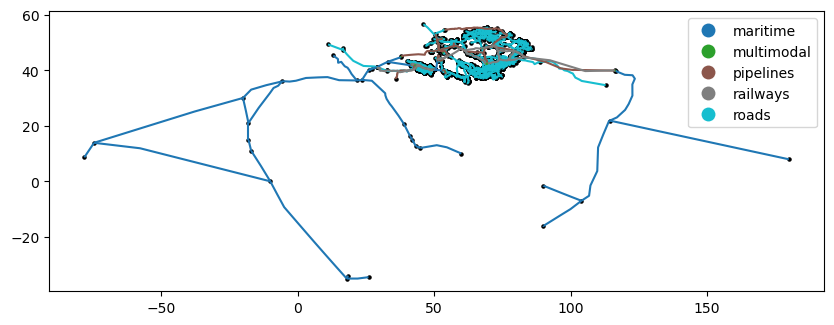

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
model.transport_edges.plot(column="type", legend=True, ax=ax, cmap="tab10")  # Use a colormap like "tab10"
model.transport_nodes.plot(ax=ax, color="black", markersize=5, label="Nodes")

In [34]:
model.transport_network.nodes[0]['geometry'].y

40.68659770997405

In [68]:
all_od_points = set(model.firm_table['od_point'].unique())
print(f"There are {len(all_od_points)} od points")

There are 587 od points


In [75]:
nx.has_path(model.transport_network, 4117, 4118)

True

In [62]:
nx.has_path(model.transport_network, 10236, 7584)

False

In [33]:
from itertools import combinations, product
import networkx as nx
from tqdm import tqdm


def identify_unconnected_pairs(graph, pairs):
    print(f"There are {len(pairs)} pairs of nodes")
    pairs_not_connected = []
    for node1, node2 in tqdm(pairs, desc="Processing pairs", total=len(pairs)):
        if not nx.has_path(model.transport_network, node1, node2):
            pairs_not_connected.append((node1, node2))
    print(f"There are {len(pairs_not_connected)} disconnected pairs")
    return pairs_not_connected


def identify_unconnected_pairs_two_sets(graph, set1, set2):
    pairs = list(product(set1, set2))
    return identify_unconnected_pairs(graph, pairs)


def identify_unconnected_pairs_one_set(graph, set1):
    pairs = list(combinations(set1, 2))
    return identify_unconnected_pairs(graph, pairs)

In [69]:
countries_not_connected = identify_unconnected_pairs_one_set(model.transport_network, set(model.countries.get_properties('od_point').values()))

There are 28 pairs of nodes


Processing pairs: 100%|██████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1559.66it/s]

There are 0 disconnected pairs


In [70]:
countries_households_not_connected = identify_unconnected_pairs_two_sets(model.transport_network, 
                                                              set(model.countries.get_properties('od_point').values()),
                                                              set(model.household_table['od_point'].unique())
                                                             )

There are 48 pairs of nodes


Processing pairs: 100%|███████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 501.33it/s]

There are 0 disconnected pairs


In [71]:
firms_households_not_connected = identify_unconnected_pairs_two_sets(model.transport_network, 
                                                                     set(model.firm_table['od_point'].unique()),
                                                                     set(model.household_table['od_point'].unique())
                                                                    )

There are 3522 pairs of nodes


Processing pairs: 100%|███████████████████████████████████████████████████████████| 3522/3522 [00:09<00:00, 357.34it/s]

There are 6 disconnected pairs


In [76]:
firms_countries_not_connected = identify_unconnected_pairs_two_sets(model.transport_network, 
                                                                     set(model.firm_table['od_point'].unique()),
                                                                     set(model.countries.get_properties('od_point').values())
                                                                    )

There are 4696 pairs of nodes


Processing pairs: 100%|███████████████████████████████████████████████████████████| 4696/4696 [00:10<00:00, 453.88it/s]

There are 8 disconnected pairs


In [78]:
firms_not_connected = identify_unconnected_pairs_one_set(model.transport_network, set(model.firm_table['od_point'].unique()))

There are 171991 pairs of nodes


Processing pairs: 100%|███████████████████████████████████████████████████████| 171991/171991 [08:12<00:00, 349.52it/s]

There are 586 disconnected pairs


In [84]:
# get nodes disconnected to many pairs
import pandas as pd
df = pd.DataFrame(firms_not_connected)
print(str(df[0].value_counts().iloc[:30].index.to_list()))
print(pd.concat([df[0]]).value_counts().index)
pd.concat([df[0], df[1]]).value_counts().iloc[:10]

[9887, 3180, 9377, 9379, 9378, 3233, 7316, 7314, 3207, 9348, 1148, 1142, 3184, 9327, 3174, 9385, 7267, 9315, 7257, 1109, 9299, 7250, 1095, 1092, 9282, 9255, 1058, 9243, 3241, 9398]
Int64Index([ 9887,  3180,  9377,  9379,  9378,  3233,  7316,  7314,  3207,
             9348,
            ...
             4593,  4589,  6637, 10731,  4583,  4582,  4572,  4570,  4569,
              786],
           dtype='int64', length=472)


9887    586
8194      1
5561      1
5554      1
3507      1
1460      1
5557      1
5556      1
1463      1
9660      1
dtype: int64

In [ ]:
country_firm_pairs = product(set(model.country_table['od_point'].unique()), set(model.firm_table['od_point'].unique()))
country_firm_not_connected = []
for country, firm in tqdm(country_firm_pairs, desc="Processing pairs"):
    if not G.has_edge(country, firm):
        country_firm_not_connected.append((country, firm))

Processing node pairs: 53642it [03:19, 252.11it/s] 

In [24]:
country_household_pairs = product(set(model.country_table['od_point'].unique()), set(model.household_table['od_point'].unique()))
country_household_not_connected = []
for country, firm in tqdm(country_household_pairs, desc="Processing pairs"):
    if not G.has_edge(country, firm):
        country_household_not_connected.append((country, firm))

AttributeError: 'Model' object has no attribute 'country_table'

In [ ]:
firm_household_pairs = product(set(model.firm_table['od_point'].unique()), set(model.household_table['od_point'].unique()))
firm_household_not_connected = []
for country, firm in tqdm(firm_household_pairs, desc="Processing pairs"):
    if not G.has_edge(country, firm):
        firm_household_not_connected.append((country, firm))

Processing node pairs: 53642it [03:19, 252.11it/s] 

In [ ]:
model.transport_edges

In [19]:
events = model.parameters.events
events[0]

{'type': 'transport_disruption',
 'description_type': 'edge_attributes',
 'attribute': 'disruption',
 'values': ['flood_1in1000_UZB'],
 'start_time': 1,
 'duration': 1}

In [20]:
from disruptsc.disruption.disruption import DisruptionList, TransportDisruption
DisruptionList.from_events_parameter(model.parameters.events,  model.parameters.monetary_units_in_model,
                                                                    model.transport_edges, model.firm_table,
                                                                    model.firms)

DisruptionList([EventDict(start_time=1, data={})])

In [22]:
disruption_object = TransportDisruption.from_edge_attributes(
                        edges=model.transport_edges,
                        attribute=events[0]['attribute'],
                        values=events[0]['values']
                    )
disruption_object

EventDict(start_time=1, data={})

In [25]:
condition = [model.transport_edges[events[0]['attribute']].str.contains(value) for value in events[0]['values']]
condition

[index
 0       None
 1       None
 2       None
 3       None
 4       None
         ... 
 1374     NaN
 1375     NaN
 1376     NaN
 1377     NaN
 1378     NaN
 Name: disruption, Length: 1379, dtype: object]

In [ ]:

condition = pandas.concat(condition, axis=1)
condition = condition.any(axis=1)